In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import AutoConfig, AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [30]:
DATA_PATH = "../data/rocov2"

In [31]:
df = pd.read_csv(os.path.join(DATA_PATH, "processed", "train_top_20_key_cf.csv"))
df.head()

,ID,Caption,CUIs,CUI_caption,keywords
0,ROCOv2_2023_train_000001,Head CT demonstrating left parotiditis.,C0040405,X-Ray Computed Tomography,"Computed Tomography, Parotid, Left side, Infla..."
1,ROCOv2_2023_train_000006,5.1 cm x 3.4 cm x 4 cm multiloculated hepatic ...,C0040405,X-Ray Computed Tomography,"Computed tomography, Liver, Bottom view, Hepat..."
2,ROCOv2_2023_train_000010,Preop CT showing left orbital floor fracture,C0040405,X-Ray Computed Tomography,"Computed Tomography, Orbital area, Floor view,..."
3,ROCOv2_2023_train_000011,Postop 22-month CT scan (sagittal): Posteriorl...,C0040405,X-Ray Computed Tomography,"Computed Tomography, Spine, Sagittal View, Nor..."
4,ROCOv2_2023_train_000014,"Sagittal T2-SPAIR image illustrating the ""flui...",C0024485;C0444611,Magnetic Resonance Imaging;Fluid behavior,"Computed Tomography, Spine, Sagittal View, Ost..."


In [32]:
config = AutoConfig.from_pretrained('zzxslp/RadBERT-RoBERTa-4m')
tokenizer = AutoTokenizer.from_pretrained('zzxslp/RadBERT-RoBERTa-4m')
radbert = AutoModel.from_pretrained('zzxslp/RadBERT-RoBERTa-4m', config=config)

Some weights of RobertaModel were not initialized from the model checkpoint at zzxslp/RadBERT-RoBERTa-4m and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
cap = df.iloc[0].keywords
inputs = tokenizer(cap, return_tensors="pt", max_length=128, truncation=True, padding="max_length")
outputs = radbert(**inputs)
outputs.last_hidden_state[:, 0, :].detach().numpy()

In [48]:
bert_res = []
for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Generating BERT output"):
    caption = row["Caption"] + " " + row["CUI_caption"]
    # caption = row["keywords"]
    inputs = tokenizer(caption, return_tensors="pt", max_length=128, truncation=True, padding="max_length")
    outputs = radbert(**inputs)
    bert_res.append(outputs.last_hidden_state[:, 0, :].detach().numpy())

df["radbert_output"] = bert_res

Generating BERT output:   0%|          | 0/9577 [00:00<?, ?it/s]

In [49]:
df.head()

,ID,Caption,CUIs,CUI_caption,keywords,radbert_output,cluster
0,ROCOv2_2023_train_000001,Head CT demonstrating left parotiditis.,C0040405,X-Ray Computed Tomography,"Computed Tomography, Parotid, Left side, Infla...","[[-0.0015480742, 0.15832254, 0.013164125, -0.1...",0
1,ROCOv2_2023_train_000006,5.1 cm x 3.4 cm x 4 cm multiloculated hepatic ...,C0040405,X-Ray Computed Tomography,"Computed tomography, Liver, Bottom view, Hepat...","[[0.059691295, 0.08208632, -0.07562837, -0.026...",2
2,ROCOv2_2023_train_000010,Preop CT showing left orbital floor fracture,C0040405,X-Ray Computed Tomography,"Computed Tomography, Orbital area, Floor view,...","[[0.017008651, 0.13905604, -0.07169691, -0.139...",3
3,ROCOv2_2023_train_000011,Postop 22-month CT scan (sagittal): Posteriorl...,C0040405,X-Ray Computed Tomography,"Computed Tomography, Spine, Sagittal View, Nor...","[[0.06705034, 0.10850134, -0.0704364, -0.05569...",3
4,ROCOv2_2023_train_000014,"Sagittal T2-SPAIR image illustrating the ""flui...",C0024485;C0444611,Magnetic Resonance Imaging;Fluid behavior,"Computed Tomography, Spine, Sagittal View, Ost...","[[-0.018530365, 0.108755514, -0.03484553, -0.0...",3


In [50]:
tsne = TSNE(n_components=2)
X = df["radbert_output"].apply(lambda x: x[0])
X = np.array(X.to_list())
X_embedded = tsne.fit_transform(X)

In [51]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(X_embedded)
df["cluster"] = kmeans.labels_

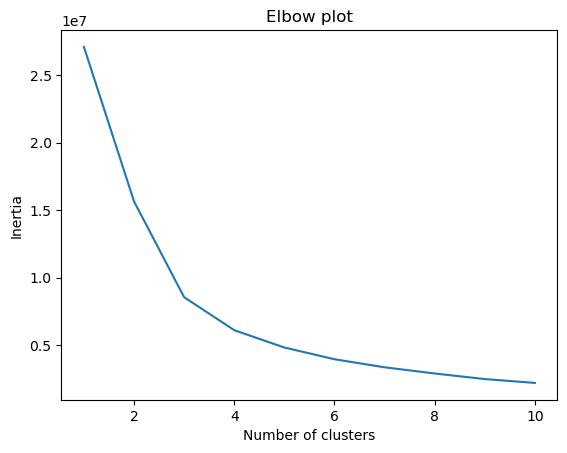

In [52]:
#compute elbow plot
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X_embedded)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow plot')
plt.show()

In [53]:
df[["keywords", "cluster"]]

,keywords,cluster
0,"Computed Tomography, Parotid, Left side, Infla...",2
1,"Computed tomography, Liver, Bottom view, Hepat...",2
2,"Computed Tomography, Orbital area, Floor view,...",2
3,"Computed Tomography, Spine, Sagittal View, Nor...",5
4,"Computed Tomography, Spine, Sagittal View, Ost...",3
...,...,...
9572,"X-ray, Chest, Front of the image, Hydropneumot...",1
9573,"X-ray, Mouth, Panoramic View, Missing teeth an...",0
9574,"Dental orthopantomogram, skull, panoramic X-ra...",0
9575,"Computed Tomography, Optic, Frontal View, Normal",0


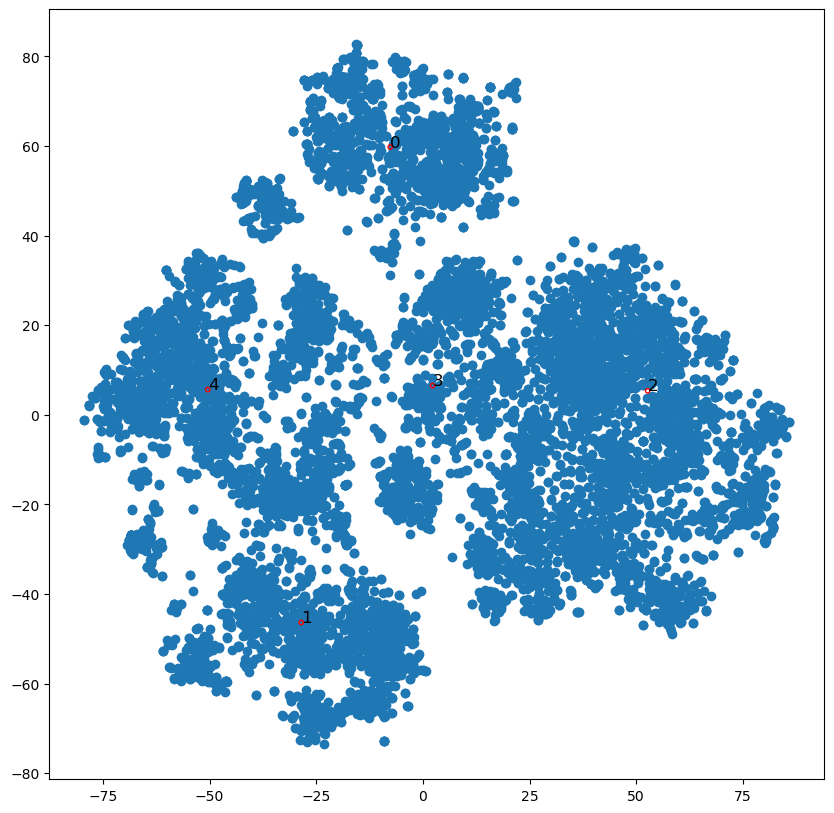

In [54]:
#plot the tsne with clusters having different colors. enclose the clusters in an oval and write the cluster number
plt.figure(figsize=(10, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])#, c=df["cluster"], cmap="viridis")
for i in range(5):
    cluster = X_embedded[df["cluster"] == i]
    x, y = cluster[:, 0], cluster[:, 1]
    x_mean, y_mean = np.mean(x), np.mean(y)
    plt.text(x_mean, y_mean, str(i), fontsize=12)
    plt.gca().add_artist(plt.Circle((x_mean, y_mean), 0.5, fill=False, color="red"))
plt.savefig("../fig/cluster_caption.png")